# 프로젝트: 인물 모드 문제점 찾기

만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

우선 주요 라이브러리 버전을 확인해 볼까요?

In [6]:
!pip install pixellib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 957.4 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.3/430.3 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.7 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 
# 내장 라이브러리

# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 
# 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음

# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여
# pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## Step 1. 인물모드 직접 해 보기   
여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.    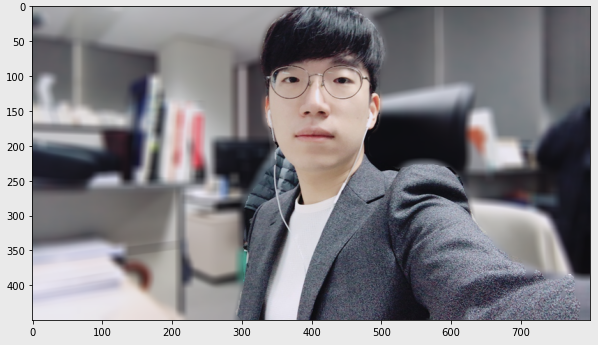

아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.	
인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.	
semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.


In [4]:
!tree

.
├── images
│   ├── image_animal.png
│   ├── image_JH.png
│   ├── JH_chroma.png
│   └── my_image.png -> /aiffel/data/my_image.png
├── models
│   └── deeplabv3_xception_tf_dim_ordering_tf_kernels.h5
├── Segmentation_Practice.ipynb
└── Segmentation_project.ipynb

2 directories, 7 files


In [5]:
# model 불러오기 - 로컬경로
import os
import urllib
import cv2 # OpenCV를 통해 이미지 처리
import numpy as np 
from pixellib.semantic import semantic_segmentation # 이번 모델
from matplotlib import pyplot as plt


In [6]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# model_dir = os.getenv('HOME')+'/Documents/dev/2024/aiffel/AIFFEL_RESEARCH_STUDY/Quests/Quest4_20240605/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7e38b6d8bb20>)

In [42]:
# 함수 정의
def seperate_image(img_path):
    '''
    사진을 입력받고, pixellib의 모델을 통해서 mask를 구합니다.
    '''
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file) 
    segvalues, output = model.segmentAsPascalvoc(img_path) 
    
    return segvalues, output

In [43]:
def show_segmap(seg_color, output):
    seg_map = np.all(output==seg_color, axis=-1) 
    print(seg_map.shape) 
    plt.imshow(seg_map, cmap='gray')
    plt.show()

In [44]:
def blurring_bgr(img, kernel_size):
    blurred = cv2.blur(img, kernel_size)
    print("흐리게 됨")
    plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
    plt.show()
    
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color) # 배경을 하얗게 반전
    img_bg_blur = cv2.bitwise_and(blurred, img_bg_mask)
    print("배경만 흐리게 됨")
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    img_concat = np.where(img_mask_color==255, img, img_bg_blur)
    print("결과물")
    
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

In [45]:
%pwd

'/aiffel/aiffel/AIFFEL_RESEARCH_STUDY/Quests/Quest4_20240605/human_segmentation'

In [46]:
project_path = '/aiffel/aiffel/AIFFEL_RESEARCH_STUDY/Quests/Quest4_20240605/human_segmentation'
img_path = project_path + '/images'


### 요구사항 : 인물모드 사진 만들기

In [47]:
img_jh = cv2.imread(img_path+'/image_JH.png')
print(img_jh.shape)

(180, 320, 3)


In [48]:
segv, output = seperate_image(img_path+'/image_JH.png')

In [49]:
print(segv['class_ids'])

[ 0 15]


In [50]:
seg_color = (128,128,192) # 15번 레이블의 칼라를 BGR순으로 변경한 값

In [51]:
seg_map = np.all(output==seg_color, axis=-1) 

(180, 320)


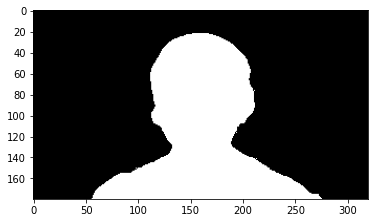

In [52]:
show_segmap(seg_color, output)

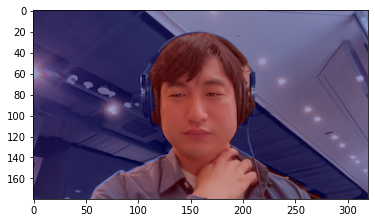

In [53]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_jh.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

흐리게 됨


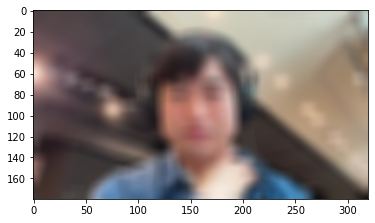

배경만 흐리게 됨


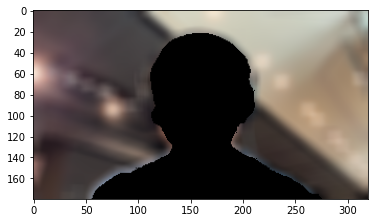

결과물


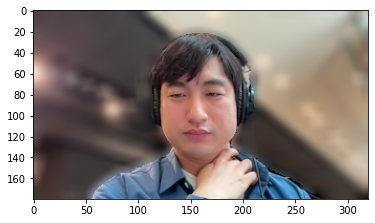

In [54]:
kernel_size = (13, 13)


    
blurring_bgr(img_jh, kernel_size)

> 배경을 흐리게 적용해보았습니다. 
#### 문제점으로 생각되는 부분
1. 헤드폰은 Blur처리가 되지 않기를 원했습니다만, blur가 되었습니다.   
    또한, 헤드폰을 착용하고 있는 부분에 살짝 비어있는 부분은 오히려 배경처리가 되지 않았습니다.
2. 경계(어깨, 머리 모양)주변으로 윤곽선이 생깁니다.
3. 확대해보면, 경계부 바로 다음 "배경" 부분은 처리가 제대로 되지 않습니다.

    인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.    

### 요구사항 : 동물 사진 만들기

In [55]:
img_dog = cv2.imread(img_path+'/image_animal.png')
print(img_dog.shape)

(640, 480, 3)


In [56]:
segv, output = seperate_image(img_path+'/image_animal.png')

In [48]:
segv, output = seperate_image(img_path+'/image_JH.png')

In [57]:
print(segv['class_ids'])

[ 0 12 15]


In [ ]:
# 12 : [ 64,   0, 128],

In [61]:
# seg_color = (128,128,192) # 15번 레이블의 칼라를 BGR순으로 변경한 값
seg_color = (128,0,64) # 12번 레이블의 칼라를 BGR순으로 변경한 값

In [62]:
seg_map = np.all(output==seg_color, axis=-1) 

(640, 480)


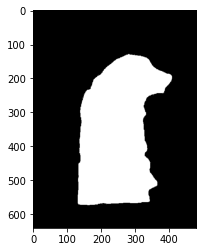

In [63]:
show_segmap(seg_color, output)

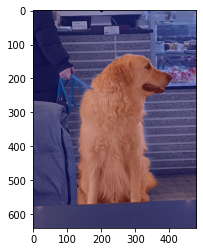

In [64]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_dog.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

흐리게 됨


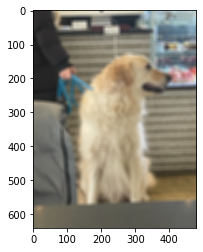

배경만 흐리게 됨


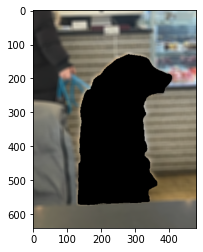

결과물


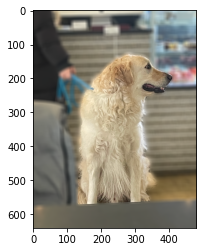

In [65]:
kernel_size = (13, 13)

blurring_bgr(img_dog, kernel_size)

    배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 
    여러분만의 환상적인 사진을 만들어 보면 어떨까요?

### 요구사항 : 배경전환 크로마키 사진 만들기

In [72]:
img_chroma = cv2.imread(img_path+'/JH_chroma.png')
print(img_chroma.shape)

(640, 480, 3)


In [66]:
segv, output = seperate_image(img_path+'/JH_chroma.png')

In [67]:
print(segv['class_ids'])

[ 0 15]


In [68]:
seg_color = (128,128,192) # 15번 레이블의 칼라를 BGR순으로 변경한 값

In [69]:
seg_map = np.all(output==seg_color, axis=-1) 

(640, 480)


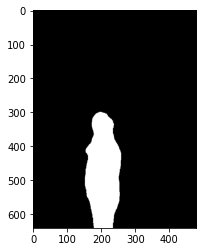

In [70]:
show_segmap(seg_color, output)

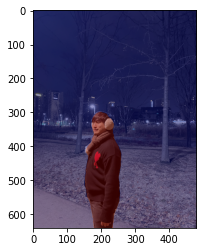

In [73]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_chroma.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

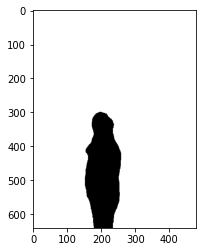

In [74]:
# 마스크 영상 제작
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 배경을 하얗게 반전

plt.imshow(cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# cv2.copyTo(frame2, mask, frame1)
cv2.copyTo(frame2, img_bg_mask, frame1)

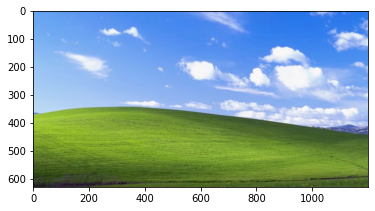

In [76]:
# 배경 불러오기
bg = cv2.imread(img_path+'/windowbg.jpeg')
plt.imshow(cv2.cvtColor(bg, cv2.COLOR_BGR2RGB))
plt.show()

In [77]:
# 영상에 맞는 크기로 변환
bg = cv2.resize(bg, (img_chroma[1],img_chroma[0]))
plt.imshow(cv2.cvtColor(bg, cv2.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type


In [78]:
# # 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
# img_show = img_chroma.copy()

# # True과 False인 값을 각각 255과 0으로 바꿔줍니다
# img_mask = seg_map.astype(np.uint8) * 255

# # 255와 0을 적당한 색상으로 바꿔봅니다
# color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, bg, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


## Step 2. 사진에서 문제점 찾기

그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다.   
어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.  
추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.  

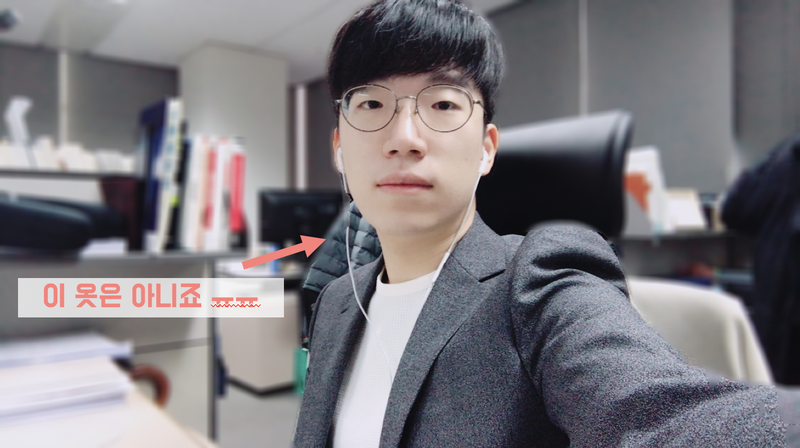

### 요구사항 : Step1에서 수행한 인물모드 사진에서 문제점을 찾아서, 표시 후 제출하기

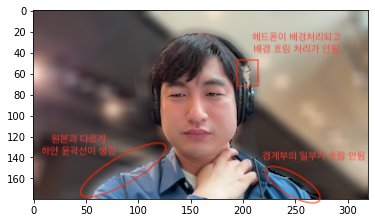

## Step 3. 해결 방법을 제안해 보기

아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, **여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안**해 주시기 바랍니다.

단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

### 1. 세그멘테이션의 한계

Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

### 2. 피사계 심도 이해하기

우선 피사계심도의 개념부터 명확히 이해해 봅시다.

- [아웃포커싱 하는 법](https://m.blog.naver.com/typs6301/222172333739)
- [얕은 피사계 심도 촬영의 이해](https://www.adobe.com/kr/creativecloud/photography/discover/shallow-depth-of-field.html)

### 3. 3D Camera 활용하기

이미지를 2D 방식으로 받아들이는 한계를 넘어 3D로 인식하려는 시도는 꽤 오래전부터 계속되어 왔습니다. 기술도 이제는 상당한 수준에 이르렀는데요. 크게는 스테레오 비전, ToF 방식 등이 자주 사용됩니다. 하드웨어 이미지 센서를 통한 3D 이미징 기술이 많이 발전되었는데요. 아래 참고 자료를 통해 최신 기술을 살펴봐도 좋습니다.

- [3D 이미지센서](https://news.skhynix.co.kr/post/next-gen-3d)

### 4. 소프트웨어 기술 활용하기

하드웨어 개발과 생산에는 비용이 많이 들기 때문에 제한된 하드웨어를 이용하면서 소프트웨어로 그 한계를 극복하려는 노력도 많습니다. 구글의 struct2Depth가 대표적인 예일 것 같습니다.

- [Unsupervised Learning of Depth and Ego-Motion: A Structured Approach](https://sites.google.com/view/struct2depth)


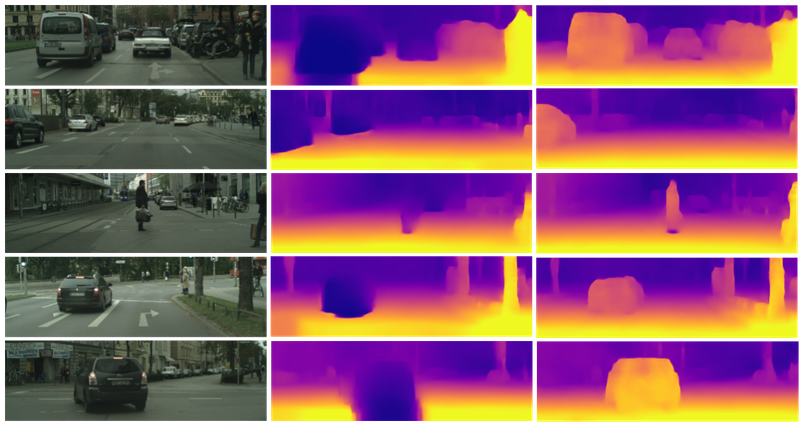
딥러닝이 발전한 지금은 더 다양한 기술이 개발되어 있으니 잘 탐색해 보세요.

### 5. 다른 기술과 융합해 보기

구글 pixel4에는 IR(적외선) 카메라가 달려있는데요. 물체의 온도를 측정하는 IR 카메라와 3D 이미지는 크게 관련이 없을 것 같지만, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.

- [uDepth: Real-time 3D Depth Sensing on the Pixel 4](https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html)

이렇게 카메라와 무관한 다른 기술과 융합하는 것도 좋은 해결책이 될 수 있습니다. 한 번 고민해 보세요!

### 요구사항 : 위에서 읽은 기술들을 토대로, 인물모드 사진의 문제점 해결방안을 정리, 제안
이 외에도 다른 방식으로 접근해도 좋습니다. 엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!

#### 인물사진 문제점
1. 헤드폰은 Blur처리가 되지 않기를 원했습니다만, blur가 되었습니다.   
    또한, 헤드폰을 착용하고 있는 부분에 살짝 비어있는 부분은 오히려 배경처리가 되지 않았습니다.
2. 경계(어깨, 머리 모양)주변으로 윤곽선이 생깁니다.
3. 확대해보면, 경계부 바로 다음 "배경" 부분은 처리가 제대로 되지 않습니다.

#### 해결 방안
- 2D이미지에서는 심도 파악에 한계가 있기 때문에, 3D 이미지 센서 도입을 통해, 심도 정보를 보다 정확하게 획득하게 되면, 헤드폰의 빈 구멍 공간이 실제 배경임을 인지할 수 있을 것임.
- 경계부에 윤곽선이 생기는 것은, 심도맵 불완전성에 기인함. IR/ToF 심도데이터를 획득하여 심도맵 생성 후, struct2Depth 보정을 진행한다면 효과가 좀 더 좋아질 것이다.
- 경계부 심도 보정 후 후처리 알고리즘(CRF(?)을 적용한다면, 좀 더 개선된 품질을 얻을 수 있을 것 같다.

```text
   +----------------------+
   |  RGB 이미지 입력        |
   +---------+------------+
             |
             v
   +---------+------------+
   |  IR 이미지 입력         |
   +---------+------------+
             |
             v
   +---------+------------+
   |  ToF 심도 데이터 획득    |
   +---------+------------+
             |
             v
   +---------+------------+
   |  데이터 융합 및 보정      |
   +---------+------------+
             |
             v
   +---------+------------+
   |  심도 맵 생성           |
   +---------+------------+
             |
             v
   +---------+------------+
   |  struct2Depth 보정    |
   +---------+------------+
             |
             v
   +---------+------------+
   |  보케 효과 적용         |
   +---------+------------+
             |
             v
   +---------+------------+
   |  최종 이미지 출력        |
   +----------------------+
   ```

# 루브릭

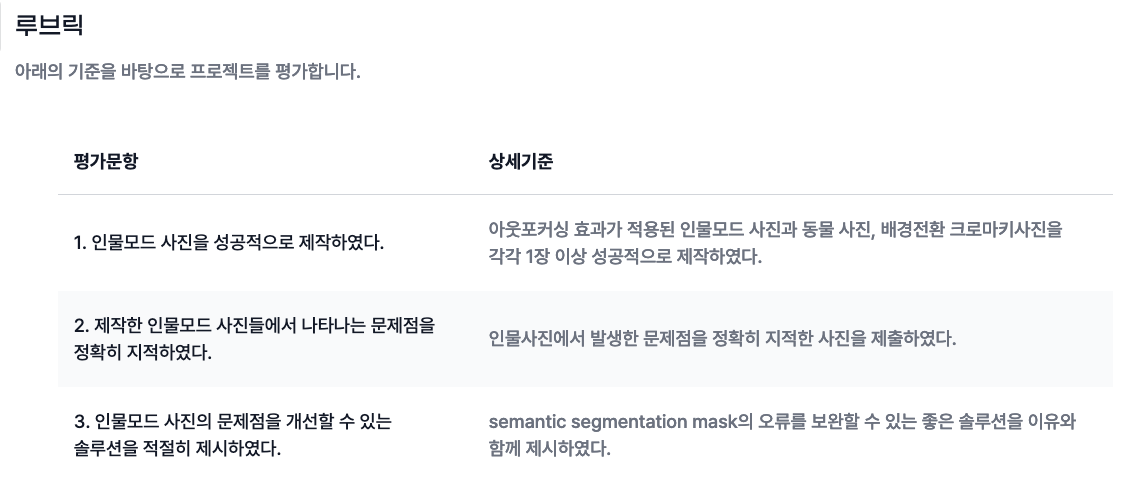

# 오늘의 회고

날짜: 2024년 6월 4일

## 학습 주제: 
딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해봅니다.

## 주요 학습 내용:
segmentation model 사용을 통해 배경과 물체? 구분을 하는 방법
kernel size를 통해 blur를 하는 법
mask, 배경 등 개별 객체들을 합쳐서 이미지 만드는 법(cv2 library 사용법)

## 실습 및 프로젝트 진행 상황:
실습은 LMS 따라서 큰 탈 없이 진행 할 수 있었음.
괜히 로컬에서 좀 해보려고 시도하다가 시간 날림(약 30분)

**크로마키 입히는 것 배경 사이즈가 달라서 실패함**

## 도전과 어려움:

로컬에서 진행을 했었기 때문에 환경설정 실패
(pixellib dependancy 이슈, 퍼실님이 LMS 강제 하심)
cv2 API 사용법이 익숙치 않아서 그림 사이즈 맞추는 것도 힘겹다.

## 느낀 점 및 개선할 점:

일과 외 시간에, 현충일에 공부를 더 해야겠다.